# Jupyter Lectures, First Year Project 2021

## Project 1 - Road collisions analysis, ITU Copenhagen

**Instructor: Michael Szell**

Course page: https://learnit.itu.dk/local/coursebase/view.php?ciid=590

This notebook contains all the code developed in the course lectures to wrangle and explore the data set from the project.

Contact: Michael Szell (misz@itu.dk)  
Created: 2021-01-29  
Last modified: 2021-02-23

<hr>

# Lecture 1: First data exploration

### Imports

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import csv

import pandas as pd

import json
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

%run -i ../scripts/functions.py

Loaded functions.



### Constants

Constants are written all caps: https://www.python.org/dev/peps/pep-0008/#constants

In [2]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" # Note the inconsistent naming of the raw data files

TABLENAMES = ["accidents", "casualties", "vehicles"]

### Load raw data

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data  
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

We first explore one data table, the accidents.
We load the data set with `utf-8-sig` encoding: https://stackoverflow.com/questions/17912307/u-ufeff-in-python-string

In [3]:
dataraw = {}
dataraw["accidents"] = np.genfromtxt(PATH["data_raw"]+FILENAME["accidents"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["vehicles"] = np.genfromtxt(PATH["data_raw"]+FILENAME["vehicles"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["casualties"] = np.genfromtxt(PATH["data_raw"]+FILENAME["casualties"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [4]:
headerraw = {}
for tablename in TABLENAMES:
    headerraw[tablename] = list(dataraw[tablename].dtype.names)

It is always good to start with a "sneak preview":

In [5]:
dataraw["accidents"][:5]

array([('2019010128300', 528218, 180407, -0.153842, 51.508057, 1, 3, 2, 3, '18/02/2019', 2, '17:50',  1, 'E09000033', 3, 4202, 1, 30, 1,  2,  3, 4202,  0,  5, 1, 1, 1, 0, 0, 1, 3, 'E01004762'),
       ('2019010152270', 530219, 172463, -0.127949, 51.436208, 1, 3, 2, 1, '15/01/2019', 3, '21:45',  9, 'E09000022', 3,   23, 2, 30, 0, -1, -1,    0, -1, -1, 4, 1, 1, 0, 0, 1, 3, 'E01003117'),
       ('2019010155191', 530222, 182543, -0.124193, 51.526795, 1, 3, 2, 1, '01/01/2019', 3, '01:50',  2, 'E09000007', 4,  504, 6, 30, 3,  4,  6,    0,  0,  0, 4, 1, 1, 0, 0, 1, 1, 'E01000943'),
       ('2019010155192', 525531, 184605, -0.191044, 51.546387, 1, 2, 1, 1, '01/01/2019', 3, '01:20',  2, 'E09000007', 4,  510, 6, 20, 3,  4,  4,  510,  0,  0, 4, 1, 1, 0, 0, 1, 1, 'E01000973'),
       ('2019010155194', 524920, 184004, -0.200064, 51.541121, 1, 3, 2, 2, '01/01/2019', 3, '00:40', 28, 'E09000005', 3, 4003, 6, 30, 6,  4,  6,    0,  0,  0, 4, 1, 1, 0, 0, 1, 1, 'E01000546')],
      dtype=[('Accident_Index

Reminder and documentation on structured arrays:  
https://numpy.org/devdocs/user/basics.rec.html

#### Insight: Mixed variable types

Accidents have mixed data types, including strins, floats, integers. Categorical variables are encoded as integers. The meaning of these categories can be looked up in: `../references/variable lookup.xls`

Number of records

In [6]:
dataraw["accidents"].shape

(117536,)

Number of fields

In [7]:
len(dataraw["accidents"].dtype)

32

In [8]:
dataraw["accidents"].dtype

dtype([('Accident_Index', '<U13'), ('Location_Easting_OSGR', '<i4'), ('Location_Northing_OSGR', '<i4'), ('Longitude', '<f8'), ('Latitude', '<f8'), ('Police_Force', '<i4'), ('Accident_Severity', '<i4'), ('Number_of_Vehicles', '<i4'), ('Number_of_Casualties', '<i4'), ('Date', '<U10'), ('Day_of_Week', '<i4'), ('Time', '<U5'), ('Local_Authority_District', '<i4'), ('Local_Authority_Highway', '<U9'), ('1st_Road_Class', '<i4'), ('1st_Road_Number', '<i4'), ('Road_Type', '<i4'), ('Speed_limit', '<i4'), ('Junction_Detail', '<i4'), ('Junction_Control', '<i4'), ('2nd_Road_Class', '<i4'), ('2nd_Road_Number', '<i4'), ('Pedestrian_CrossingHuman_Control', '<i4'), ('Pedestrian_CrossingPhysical_Facilities', '<i4'), ('Light_Conditions', '<i4'), ('Weather_Conditions', '<i4'), ('Road_Surface_Conditions', '<i4'), ('Special_Conditions_at_Site', '<i4'), ('Carriageway_Hazards', '<i4'), ('Urban_or_Rural_Area', '<i4'), ('Did_Police_Officer_Attend_Scene_of_Accident', '<i4'), ('LSOA_of_Accident_Location', '<U9')])

**"Data in the wild" puzzle: Why is the first field "\ufeffAccident_Index" and not "Accident_Index"?**

We load the data set with `utf-8-sig` encoding: https://stackoverflow.com/questions/17912307/u-ufeff-in-python-string

Fields

In [9]:
dataraw["accidents"].dtype.names

('Accident_Index',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date',
 'Day_of_Week',
 'Time',
 'Local_Authority_District',
 'Local_Authority_Highway',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Pedestrian_CrossingHuman_Control',
 'Pedestrian_CrossingPhysical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'LSOA_of_Accident_Location')

Homework: Explore the other two tables the same way.

https://en.wikipedia.org/wiki/Code_refactoring

<hr>

# Lecture 2: Command line wrangling and dealing with missing data

A faster way of getting basic insights into a new data set than by using numpy is by using command line tools.

Let's get a first overview using `head`. There are 3 data tables: Accidents, Casualties, and Vehicles.

In [10]:
!head -n 6 "../data/raw/Road Safety Data - Accidents 2019.csv"
!head -n 6 "../data/raw/Road Safety Data - Casualties 2019.csv"
!head -n 6 "../data/raw/Road Safety Data- Vehicles 2019.csv"

'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.


### General insights

#### Link between data tables

Records between data tables are linked through their `Accident_Index`.

Looking at the first Accident_Index 2019010128300, we can see there seems to be a one-to-many relation between accident->casualty and accident->vehicle, meaning there can be multiple casualties and vehicles involved in one accident (makes sense).

https://en.wikipedia.org/wiki/One-to-many_(data_model)

#### Dimensions

Number of records

https://en.wikipedia.org/wiki/Wc_(Unix)

In [11]:
!wc -l "../data/raw/Road Safety Data - Accidents 2019.csv"
!wc -l "../data/raw/Road Safety Data - Casualties 2019.csv"
!wc -l "../data/raw/Road Safety Data- Vehicles 2019.csv"

'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.


Number of fields (in first line)

https://www.geeksforgeeks.org/awk-command-unixlinux-examples/

In [12]:
!head -1 "../data/raw/Road Safety Data - Accidents 2019.csv" | awk -F ',' '{print NF}'
!head -1 "../data/raw/Road Safety Data - Casualties 2019.csv" | awk -F ',' '{print NF}'
!head -1 "../data/raw/Road Safety Data- Vehicles 2019.csv" | awk -F ',' '{print NF}'

'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.


See and count all fields

https://en.wikipedia.org/wiki/Tr_(Unix)
https://en.wikipedia.org/wiki/Nl_(Unix)

In [13]:
!head -1 "../data/raw/Road Safety Data - Accidents 2019.csv" | tr ',' '\n' | nl
!head -1 "../data/raw/Road Safety Data - Casualties 2019.csv" | tr ',' '\n' | nl
!head -1 "../data/raw/Road Safety Data- Vehicles 2019.csv" | tr ',' '\n' | nl

'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.


### Sanity checks

Has each record the same number of fields?

https://shapeshed.com/unix-uniq/  
https://www.putorius.net/uniq-command-linux.html

In [14]:
!awk -F ',' '{print NF}' "../data/raw/Road Safety Data - Accidents 2019.csv" | sort | uniq -d
!awk -F ',' '{print NF}' "../data/raw/Road Safety Data - Casualties 2019.csv" | sort | uniq -d
!awk -F ',' '{print NF}' "../data/raw/Road Safety Data- Vehicles 2019.csv" | sort | uniq -d

'awk' is not recognized as an internal or external command,
operable program or batch file.
'awk' is not recognized as an internal or external command,
operable program or batch file.
'awk' is not recognized as an internal or external command,
operable program or batch file.


How many duplicate lines are there? (If more than 0, there could be a problem)

In [15]:
!sort "../data/raw/Road Safety Data - Accidents 2019.csv" | uniq -d | wc -l
!sort "../data/raw/Road Safety Data - Casualties 2019.csv" | uniq -d | wc -l
!sort "../data/raw/Road Safety Data- Vehicles 2019.csv" | uniq -d | wc -l

'uniq' is not recognized as an internal or external command,
operable program or batch file.
'uniq' is not recognized as an internal or external command,
operable program or batch file.
'uniq' is not recognized as an internal or external command,
operable program or batch file.


More advanced stuff with `awk`: https://datafix.com.au/BASHing/2020-05-20.html

## Dealing with missing data

Using a masked array:  
https://numpy.org/devdocs/reference/maskedarray.baseclass.html#numpy.ma.MaskedArray

In [16]:
dataraw_masked = {}
for tablename in TABLENAMES:
    dataraw_masked[tablename] = np.genfromtxt(PATH["data_raw"] + FILENAME[tablename], delimiter = ',', dtype = None, names = True, encoding='utf-8-sig', usemask = True)

In [17]:
dataraw_masked["accidents"][:5]

masked_array(data=[('2019010128300', 528218, 180407, -0.153842, 51.508057, 1, 3, 2, 3, '18/02/2019', 2, '17:50', 1, 'E09000033', 3, 4202, 1, 30, 1, 2, 3, 4202, 0, 5, 1, 1, 1, 0, 0, 1, 3, 'E01004762'),
                   ('2019010152270', 530219, 172463, -0.127949, 51.436208, 1, 3, 2, 1, '15/01/2019', 3, '21:45', 9, 'E09000022', 3, 23, 2, 30, 0, -1, -1, 0, -1, -1, 4, 1, 1, 0, 0, 1, 3, 'E01003117'),
                   ('2019010155191', 530222, 182543, -0.124193, 51.526795, 1, 3, 2, 1, '01/01/2019', 3, '01:50', 2, 'E09000007', 4, 504, 6, 30, 3, 4, 6, 0, 0, 0, 4, 1, 1, 0, 0, 1, 1, 'E01000943'),
                   ('2019010155192', 525531, 184605, -0.191044, 51.546387, 1, 2, 1, 1, '01/01/2019', 3, '01:20', 2, 'E09000007', 4, 510, 6, 20, 3, 4, 4, 510, 0, 0, 4, 1, 1, 0, 0, 1, 1, 'E01000973'),
                   ('2019010155194', 524920, 184004, -0.200064, 51.541121, 1, 3, 2, 2, '01/01/2019', 3, '00:40', 28, 'E09000005', 3, 4003, 6, 30, 6, 4, 6, 0, 0, 0, 4, 1, 1, 0, 0, 1, 1, 'E01000546')],
   

In [18]:
dataraw_masked["accidents"].mask[:5]

array([(False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False),
       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False),
       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False),
       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False),
       (False, False, False, False, False, False, False, False, Fals

The first 5 rows seem complete. What about the rest?

In [19]:
np.count_nonzero(dataraw_masked["accidents"].mask)

5776

Oh oh, around 5% of rows have missing values. Which rows?

In [20]:
row_incomplete = np.where(dataraw_masked["accidents"].mask)[0]
print(row_incomplete)

[   578    582   2326 ... 117533 117534 117535]


How many values in total?  
Which fields are missing?

In [21]:
missingpositions = {}
missingvalues = 0
missingconfigurations = set()
for rowpos in row_incomplete:
    missingpositions_thisrow = list(np.where(list(dataraw_masked["accidents"].mask[rowpos]))[0])
    missingpositions[rowpos] = missingpositions_thisrow
    missingvalues += len(missingpositions_thisrow)
    missingconfigurations.add(tuple(missingpositions_thisrow))
    
missingfieldnames = [np.array(headerraw["accidents"])[c] for c in [list(b) for b in missingconfigurations]]

Summary of missing values:

In [22]:
print("Incomplete rows: " + str(np.count_nonzero(dataraw_masked["accidents"].mask)))
print("Missing values: " + str(missingvalues))

print("\nMissing field configurations: " + str(missingconfigurations))
for i in missingfieldnames:
    print(i)

Incomplete rows: 5776
Missing values: 5889

Missing field configurations: {(11, 31), (1, 2, 3, 4, 31), (11,), (31,)}
['Time' 'LSOA_of_Accident_Location']
['Location_Easting_OSGR' 'Location_Northing_OSGR' 'Longitude' 'Latitude'
 'LSOA_of_Accident_Location']
['Time']
['LSOA_of_Accident_Location']


<hr>

# Lecture 3: Visual data exploration, Connecting tables, Association test

## Visual exploratory data analysis ("Plot your data")

### Bar plots of categorical variables

In [23]:
headerraw["accidents"]

['Accident_Index',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date',
 'Day_of_Week',
 'Time',
 'Local_Authority_District',
 'Local_Authority_Highway',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Pedestrian_CrossingHuman_Control',
 'Pedestrian_CrossingPhysical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'LSOA_of_Accident_Location']

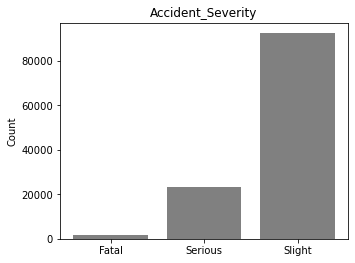

In [24]:
field_name = "Accident_Severity"
field_categories = {1: "Fatal", 2: "Serious", 3: "Slight"}

categories, counts = np.unique(dataraw["accidents"][field_name], return_counts=True)

fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.bar(categories, counts, fc="gray") # fc is the face color

axes.set_xlabel("")
axes.set_ylabel('Count')
axes.set_title(field_name)

axes.set_xticks(list(field_categories.keys()))
axes.set_xticklabels(field_categories.values());

We were lucky because the categories 1,2,3 were "nice". But usually they aren't, so we need to explicitly map to integers:

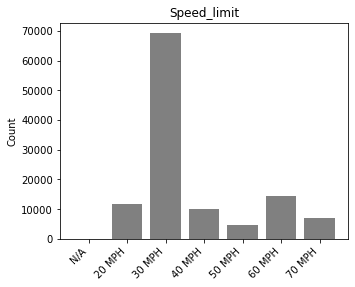

In [25]:
field_name = "Speed_limit"
field_categories = {20: "20 MPH", 30: "30 MPH", 40: "40 MPH", 50: "50 MPH", 60: "60 MPH", 70: "70 MPH", -1: "N/A"}

categories, counts = np.unique(dataraw["accidents"][field_name], return_counts=True)

fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.bar(range(len(categories)), counts, fc="gray") # fc is the face color

axes.set_xlabel("")
axes.set_ylabel('Count')
axes.set_title(field_name)
fig.autofmt_xdate(rotation=45)

axes.set_xticks(range(len(categories)))
axes.set_xticklabels([field_categories[c] for c in categories]);

Instead of copy-pasting code, let's write a function.

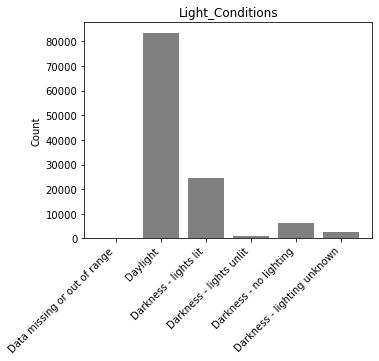

In [26]:
field_name = "Light_Conditions"
field_categories = {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 7: "Darkness - lighting unknown", -1: "Data missing or out of range"}

barplot(dataraw["accidents"], field_name, field_categories)

Typing the variable lookup manually is cumbersome. Can we read the excel directly?  
pandas can: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

In [27]:
variable_lookup = pd.read_excel("../references/variable lookup.xls", sheet_name = None)

In [28]:
print(variable_lookup.keys())
print("\n")
print(variable_lookup["Introduction"])

dict_keys(['Introduction', 'Export Variables', 'Police Force', 'Accident Severity', 'Day of Week', 'Local Authority (District)', 'Local Authority (Highway)', '1st Road Class', 'Road Type', 'Speed Limit', 'Junction Detail', 'Junction Control', '2nd Road Class', 'Ped Cross - Human', 'Ped Cross - Physical', 'Light Conditions', 'Weather', 'Road Surface', 'Special Conditions at Site', 'Carriageway Hazards', 'Urban Rural', 'Police Officer Attend', 'Vehicle Type', 'Towing and Articulation', 'Vehicle Manoeuvre', 'Vehicle Location', 'Junction Location', 'Skidding and Overturning', 'Hit Object in Carriageway', 'Veh Leaving Carriageway', 'Hit Object Off Carriageway', '1st Point of Impact', 'Was Vehicle Left Hand Drive', 'Journey Purpose', 'Sex of Driver', 'Age Band', 'Vehicle Propulsion Code', 'Casualty Class', 'Sex of Casualty', 'Age of Casualty', 'Casualty Severity', 'Ped Location', 'Ped Movement', 'Car Passenger', 'Bus Passenger', 'Ped Road Maintenance Worker', 'Casualty Type', 'IMD Decile', '

### Histograms of numerical variables

In [29]:
headerraw["casualties"]

['Accident_Index',
 'Vehicle_Reference',
 'Casualty_Reference',
 'Casualty_Class',
 'Sex_of_Casualty',
 'Age_of_Casualty',
 'Age_Band_of_Casualty',
 'Casualty_Severity',
 'Pedestrian_Location',
 'Pedestrian_Movement',
 'Car_Passenger',
 'Bus_or_Coach_Passenger',
 'Pedestrian_Road_Maintenance_Worker',
 'Casualty_Type',
 'Casualty_Home_Area_Type',
 'Casualty_IMD_Decile']

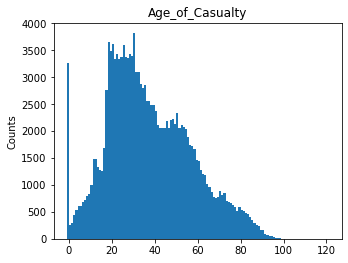

In [30]:
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(dataraw["casualties"]["Age_of_Casualty"], bins = np.linspace(-1,121, 123));

axes.set_ylabel('Counts')
axes.set_title("Age_of_Casualty");

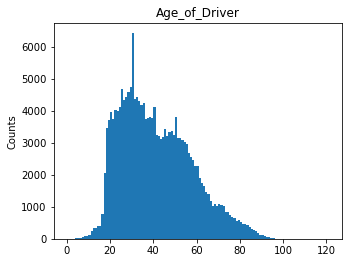

In [31]:
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(dataraw["vehicles"]["Age_of_Driver"], bins = np.linspace(0,121, 122));

axes.set_ylabel('Counts')
axes.set_title("Age_of_Driver");

### Categorical scatterplots

Scatterplots are good for relating two numerical variables. If we have one numerical versus one categorical variable, we can do a box plot. But could we also visualize all data points? Yes: https://seaborn.pydata.org/tutorial/categorical.html

In [32]:
import seaborn as sns

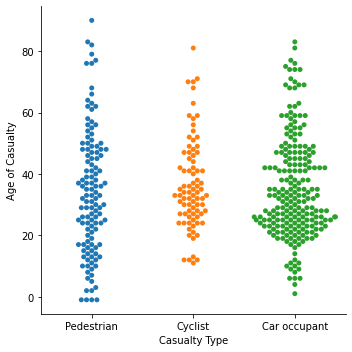

In [33]:
# Filter
mask = (dataraw["casualties"]["Casualty_Type"] == 0) | (dataraw["casualties"]["Casualty_Type"] == 1) | (dataraw["casualties"]["Casualty_Type"] == 9) &    (dataraw["casualties"]["Age_of_Casualty"] > -1)
mask[600:] = False # Restrict to at most 600 points

data_toplot = np.array([dataraw["casualties"]["Casualty_Type"][mask], dataraw["casualties"]["Age_of_Casualty"][mask]]).T

# Plot
fig = sns.catplot(x = 'Casualty Type', y = 'Age of Casualty', data = pd.DataFrame(data_toplot, columns=['Casualty Type', 'Age of Casualty']), kind = "swarm") # also show: violin
fig.set_xticklabels(["Pedestrian", "Cyclist", "Car occupant"]);

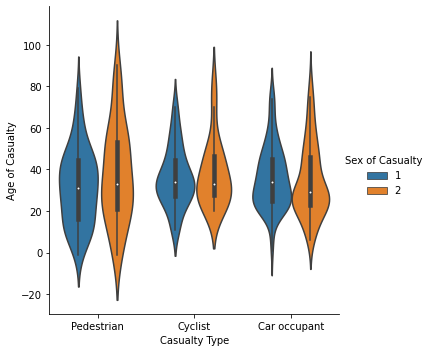

In [34]:
mask = (dataraw["casualties"]["Casualty_Type"] == 0) | (dataraw["casualties"]["Casualty_Type"] == 1) | (dataraw["casualties"]["Casualty_Type"] == 9) & (dataraw["casualties"]["Age_of_Casualty"] > -1) & (dataraw["casualties"]["Sex_of_Casualty"] > -1)
mask[600:] = False

data_toplot = np.array([dataraw["casualties"]["Casualty_Type"][mask], dataraw["casualties"]["Age_of_Casualty"][mask], dataraw["casualties"]["Sex_of_Casualty"][mask]]).T

fig = sns.catplot(x='Casualty Type', y='Age of Casualty', hue='Sex of Casualty', data=pd.DataFrame(data_toplot, columns=['Casualty Type', 'Age of Casualty', 'Sex of Casualty']), kind="violin") # also show: violin
fig.set_xticklabels(["Pedestrian", "Cyclist", "Car occupant"]);

## Connecting tables with np.isin()

**Question: How many babies and toddlers died or got injured on UK roads in June 2019?**

1. Get all the accident indices from the accidents table for June
2. Filter al casualties for those indices
3. Filter those casualties for ages 0-4

Numpy has the fucntion isin() to select for a list of indices: https://numpy.org/doc/stable/reference/generated/numpy.isin.html

In [35]:
# 1
ind = [x["Accident_Index"] for x in dataraw["accidents"] if "/06/" in x["Date"]]
# 2
datafiltered = dataraw["casualties"][np.isin(dataraw["casualties"]["Accident_Index"], ind)]
# 3
datafiltered = datafiltered[(datafiltered["Age_of_Casualty"] >= 0) & (datafiltered["Age_of_Casualty"] <= 4)]

len(datafiltered)

196

**Question: Who killed or injured them?**

Homework

## Association test between two categorical variables 
**(Pearson $\chi^2$ test of independence)**

Inspired by:  
https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2a-Test.html  
https://bit.ly/3kbwKEL

**Let us ask: Is there a statistically significant association between accident severity and speed limit?**  
We ask because speed limit is something that the city government can regulate.

### Hypothesis testing

We are now in the realm of [Statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). In general, we must first state and compare two hypotheses:

- $H_0$ (null hypothesis): There is no statistically significant relationship between accident severity and speed limit.
- $H_\alpha$ (alternative hypothesis): There is a statistically significant relationship between accident severity and speed limit.

We must then 1) state+check statistical assumptions, 2) choose an appropriate test and test statistic $T$, 3) derive the distribution for the test statistic, 4) select a significance level $\alpha$, usually 0.01 or 0.05, 5) calculate the observed test statistic $t_{\mathrm obs}$, 6) calculate the [p-value](https://en.wikipedia.org/wiki/P-value). 

If the p-value $< \alpha$, then the null hypothesis will be rejected.

### Pearson $\chi^2$ test of independence

To test association between two categorical variables, one uses the [Pearson chi-square test of independence](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test). If the significance of this test (p-value) is below a significance level (typically 0.05), the two variables have a significant association.

The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.

In [36]:
from scipy.stats import chi2_contingency

In [37]:
mask = (dataraw["accidents"]["Speed_limit"] != -1)
severityspeed = np.array([dataraw["accidents"]["Speed_limit"][mask], dataraw["accidents"]["Accident_Severity"][mask]]).T
print(severityspeed.shape)
print(severityspeed)

(117456, 2)
[[30  3]
 [30  3]
 [30  3]
 ...
 [60  3]
 [30  3]
 [60  2]]


We crosstabulate using pandas:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

The cross tabulation is also known as contingency table.

In [38]:
observed_pd = pd.crosstab(severityspeed[:, 0], severityspeed[:, 1], rownames = ["Speed limit"], colnames = ["Accident Severity"]) 
observed = observed_pd.to_numpy()
observed_pd

Accident Severity,1,2,3
Speed limit,,,
20,55,1859,9833
30,544,12995,55766
40,185,2115,7721
50,118,994,3604
60,551,4091,9872
70,205,1363,5585


The idea is now to compare these observed values with expected values.  
The expected values can be calculated using:
\begin{equation*}
E_{i,j} = \frac{R_i \times C_j}{N}
\end{equation*}
The $E_{i,j}$ indicates the expected count in row i, column j. The $R_i$ is the row total of row i, and $C_j$ the column total of column j. The $N$ is the grand total.

In [39]:
expected = np.zeros(observed.shape, dtype=int) # E, int for being more human-readable
colTotals = observed.sum(axis = 0) # C
rowTotals = observed.sum(axis = 1) # R
N = rowTotals.sum()

for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        expected[i,j] = (rowTotals[i] * colTotals[j]) / N
        
expected

array([[  165,  2341,  9239],
       [  978, 13817, 54509],
       [  141,  1997,  7881],
       [   66,   940,  3709],
       [  204,  2893, 11415],
       [  100,  1426,  5625]])

That was the manual way of doing it. `chi2_contingency()` can do it for us automatically:

In [40]:
chiVal, pVal, df, expected = chi2_contingency(observed)
chiVal, pVal, df, expected.astype(int)

(1951.0278960291566,
 0.0,
 10,
 array([[  165,  2341,  9239],
        [  978, 13817, 54509],
        [  141,  1997,  7881],
        [   66,   940,  3709],
        [  204,  2893, 11415],
        [  100,  1426,  5625]]))

We now know that the association is significant, but how strong is it?  
Cramer's V, for example, can give an answer: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

The formula is:
\begin{equation*}
V=\sqrt{\frac{\chi^{2} / N}{\min (c-1, r-1)}}
\end{equation*}
where $c$ is the number of columns, $r$ is the number of rows.

In [41]:
V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
V

0.09113372842702146

A V close to 0 implies a weak effect.

Let us visualize this and make a human-readable plot and report below.

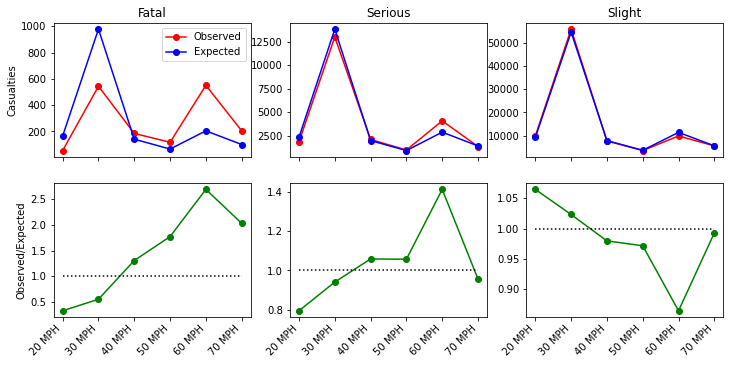

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

severity_labels = ["Fatal", "Serious", "Slight"]
speed_categories = {20: "20 MPH", 30: "30 MPH", 40: "40 MPH", 50: "50 MPH", 60: "60 MPH", 70: "70 MPH"}
x = np.array(list(speed_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Casualties')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

**Conclusion**

An association only tells us about correlation, not causation. However, in this case, there is good reason to say that the speed of cars are a cause of the accident severity. Although Cramer's V is low, there is a very clear effect, especially for fatal collisions, $\chi^2$(10, N = 117456) = 1951.03, p < .001, V = 0.091.

The conclusion is therefore that **"Speed kills"**:  
Fatal collisions are over 2 times more likely than expected for high speeds (>60 mph), and are 2-3 times less likely than expected for low speed limits (<30 mph). An urban planning policy recommendation would therefore be: To reduce fatalities, reduce speed limits.

What about statistical tests for different combinations of numerical/categorical variables?
<img src="../references/flowchart-for-choosing-a-statistical-test.png" width="600px"/>

<hr>

# Lecture 4: Spatial filtering

Data set downloaded on Jan 20th, 2021 from here: https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-area-december-2011-ew-bsc-v2/data
As of feb 19, 2021, the data set is down.

In [ ]:
cityname = "Bristol"
cityid = "bristol"

## Filtering with external table

In [ ]:
lsoa = np.genfromtxt(PATH["data_external"] + "Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2.csv", delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [ ]:
lsoa

Let's select all rows for the city name:

In [ ]:
np.count_nonzero(lsoa["LSOA11NM"] == cityname)

This didn't work. Why? A: We need to find a substring.

Solution: https://stackoverflow.com/questions/38974168/finding-entries-containing-a-substring-in-a-numpy-array

In [ ]:
city_LSOA11CD_rows = np.flatnonzero(np.core.defchararray.find(lsoa['LSOA11NM'],cityname)!=-1)
city_LSOA11CD = lsoa['LSOA11CD'][city_LSOA11CD_rows]
city_LSOA11CD

We want to use this list of LSOA11 codes to restrict our accident data set.

In [ ]:
city_accidentindices = dataraw["accidents"]["Accident_Index"][np.isin(dataraw["accidents"]["LSOA_of_Accident_Location"], city_LSOA11CD)]
len(city_accidentindices)

Filter

In [ ]:
datacity = {}
for tablename in TABLENAMES:
    datacity[tablename] = dataraw[tablename][np.isin(dataraw[tablename]["Accident_Index"], city_accidentindices)]

Export

In [ ]:
for tablename in TABLENAMES:
    with open(PATH["data_interim"] + tablename + "_" + cityid + ".csv", "w") as f:
        w = csv.writer(f)
        w.writerow(dataraw[tablename].dtype.names)
        w.writerows(datacity[tablename])

## Basics of geography (geographical information science)

https://en.wikipedia.org/wiki/Latitude  
https://en.wikipedia.org/wiki/Prime_meridian  
https://en.wikipedia.org/wiki/Map_projection  
https://en.wikipedia.org/wiki/Earth_radius  
https://en.wikipedia.org/wiki/Geoid  
https://en.wikipedia.org/wiki/World_Geodetic_System  
https://en.wikipedia.org/wiki/Grid_reference_system

Our variables `*_OSGR` are based on this:
https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid

## Spatial filtering with shapely

In [ ]:
with open(PATH["data_processed"] + "citieslad.json") as f:
    cities_json = json.load(f)

In [ ]:
cities_json[cityname]["geometry"]

In [ ]:
city_boundary = shapely.geometry.shape(cities_json[cityname]["geometry"])
type(city_boundary)

Jupyter visualizes shapely objects!

In [ ]:
city_boundary

In [ ]:
city_boundary.geom_type

Let's get all accident coordinates (from the whole UK)

In [ ]:
lon_list = dataraw["accidents"]["Longitude"]
lat_list = dataraw["accidents"]["Latitude"]

`contains()` and `within()` check for point inclusion:

In [ ]:
print(city_boundary.contains(Point(lon_list[0], lat_list[0])))
print(city_boundary.contains(Point(lon_list[102135], lat_list[102135])))

In [ ]:
city_acc_rowindices = []
for i in range(len(lon_list)):
    if Point(lon_list[i], lat_list[i]).within(city_boundary):
        city_acc_rowindices.append(i)

In [ ]:
len(city_acc_rowindices)

In [ ]:
datacity = {}
datacity["accidents"] = dataraw["accidents"][city_acc_rowindices]
len(datacity["accidents"])

In [ ]:
with open(PATH["data_interim"] + "accidents_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["accidents"].dtype.names)
    w.writerows(datacity["accidents"])

Limit vehicles and casualties to these AccidentIndices

In [ ]:
datacity["vehicles"] = dataraw["vehicles"][np.isin(dataraw["vehicles"]["Accident_Index"], datacity["accidents"]["Accident_Index"])]
datacity["casualties"] = dataraw["casualties"][np.isin(dataraw["casualties"]["Accident_Index"], datacity["accidents"]["Accident_Index"])]

In [ ]:
len(datacity["accidents"]), len(datacity["vehicles"]), len(datacity["casualties"])

In [ ]:
with open(PATH["data_interim"] + "vehicles_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["vehicles"].dtype.names)
    w.writerows(datacity["vehicles"])

with open(PATH["data_interim"] + "casualties_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["casualties"].dtype.names)
    w.writerows(datacity["casualties"])

In [ ]:
!diff ../data/interim/accidents_bristol.csv ../data/interim/accidents_bristollad.csv

What does it mean?  
See: https://www.computerhope.com/unix/udiff.htm

<hr>

# Lecture 5: Visualizing spatial data

Inspired by: https://alysivji.github.io/getting-started-with-folium.html

In [ ]:
latlons = np.vstack((datacity["accidents"]['Latitude'], datacity["accidents"]['Longitude'])).T

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m1 = folium.Map(centroid, zoom_start=11)

for row in datacity["accidents"]:
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius = 5,
                        popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                        fill_color = "#3db7e4",
                       ).add_to(m1)

HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1)
m1

The heatmap is built with KDE:  
https://en.wikipedia.org/wiki/Kernel_density_estimation

We can also add automatic clusters:

In [ ]:
latlons = np.vstack( (datacity["accidents"]['Latitude'], datacity["accidents"]['Longitude'])).T

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m2 = folium.Map(centroid, zoom_start=11)

marker_cluster = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters').add_to(m2))

for row in datacity["accidents"]:
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius = 5,
                        popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                        fill_color = "#3db7e4",
                       ).add_to(marker_cluster)

HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m2))
folium.LayerControl().add_to(m2)
m2